# Nest network from scratch

This notebook contains explanations and is useful for debugging. The code in this notebook is implemented in `SimulationClass.py`. 

## Import dependencies

In [224]:
# nest
import nest
import nest.raster_plot
import nest.voltage_trace
# other
import os
import json
import time # to track how long simulation takes
import timeit
import itertools
import numpy as np
from importlib import reload # to reload the module when making changes
from itertools import permutations # for creating the permutations
from itertools import combinations 
import matplotlib.pyplot as plt
import seaborn as sns
# horay for beautiful plots
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# set the path
path = 'data/'

# magic commands
#%matplotlib notebook

#np.random.seed(1)

## 1 Make permutations

In [225]:
# choose a seed
seed = [1,1,1,1,0,0,0,0]
patterns = []

def binary_permutations(lst):
        '''
        Returns all permutations for given binary list
        '''
        for comb in itertools.combinations(range(len(lst)), lst.count(1)):
            result = [0] * len(lst)
            for i in comb:
                result[i] = 1
            yield result
        return 
    
# make permutations for 8 bit pattern
for perm in binary_permutations(seed):
    patterns.append(perm)

print(f'Number of permutations: {len(patterns)}')

Number of permutations: 70


In [226]:
def list2str(list):
    mystr = ''
    mystr = mystr.join([str(x) for x in list])
    return mystr

## 2.1 Set parameters

- the neuron parameters are stored in a dictionary
- `iaf_cond_alpha` is an implementation of a spiking neuron using IAF dynamics with  
  conductance-based synapses. Incoming spike events induce a post-synaptic change  
  of conductance modelled by an alpha function. The alpha function  
  is normalised such that an event of weight 1.0 results in a peak current of 1 nS  
  at t = tau_syn.  

In [227]:
N_total = 1200

NE = int((N_total/5)*4) 
NI = int((N_total/5)*1) 

neuron_model = 'iaf_cond_alpha' # select neuron model from NEST library
neuron_groups = 8

# set neuron parameters
neuron_params = {
    'C_m': 250.0,
    'E_L': -70.0,
    'E_ex': 0.0,
    'E_in': -80.0,
    'I_e': 0.0,
    'V_reset': -70.0,
    'V_th': -50.0,
    'g_L': 16.7,
    't_ref': 2.0,
    'tau_syn_ex': 0.326,
    'tau_syn_in': 0.326,
}

J_ex = 6.
#J_in = -95.
J_in = -46.
eps = 0.1  # connection probability

resolution = 0.1  # this is the simulation step size in ms. Kumar2008: 0.1 
delay = 1.5  # synaptic delay in the network
n_threads = 8 # number of threads to use

## SIMULATION ##
simtime = 1000. # simulation time
stim_start = 0.    # start time of dc (stimulation time)
stim_end = 100.  # end time of dc 

## 2.2 Set amplitudes for the dc generator

In [228]:
def set_stim_amps(sub_fr=0.9, sup_fr=1.01):
    '''adjust the stimulation amplitudes to be slighly sub and supra threshold'''
    I_th = (neuron_params['V_th'] - neuron_params['E_L']) * neuron_params['g_L']
    stim_amps = np.array([sub_fr, sup_fr]) * I_th
    print(f'stimulation amplitudes: {stim_amps}')
    return stim_amps

In [229]:
stim_amps = set_stim_amps()

# try dc generator with sub and supra threshold current
Asub = stim_amps[0]
Asupra = stim_amps[1]

stimulation amplitudes: [300.6  337.34]


## 3 Build the Network

## 3.1 Reset kernel and set resolution

- Reset the simulation kernel (ensure that previous NEST simulations in the python shell will not disturb this simulation)
- set the simulation resolution

In [230]:
nest.ResetKernel()
nest.SetKernelStatus({'resolution': resolution})

In [231]:
#?nest.ResetNetwork()

## 3.2 Create the neurons, generator and meters

- create a population of neurons with specified neuron model and parameters defined above
- create a dc_generator, which will apply a constant current to some neurons
- create a spikedetector that tracks when the neurons spike
- create a multimeter that tracks the voltage of neurons

--- 

**Multimeter** replaces a range of analog recording devices, such as voltmeter, conductancemeter and aeif_w_meter

---

### 3.2.1 Neuron populations

The Nest module currently does not support indexing a neuron population by a list of indices. This seems like a potential way to do it as well.

- take a binary pattern
- assign each group of neurons (8) to be either sub or supra threshold
- combine neurons into two groups


In [232]:
# size of one neuron group 
group_size = int((N_total / neuron_groups))
print(group_size)

# an example pattern
pattern = patterns[40]

SUB_pop = []
SUPRA_pop = []

for i in range(len(pattern)):

    # set defaults for the neuron populations
    nest.SetDefaults('iaf_cond_alpha', neuron_params)
        
    if pattern[i] == 1:
        n_supra = nest.Create('iaf_cond_alpha', group_size)
        
        SUPRA_pop.append(n_supra)
    
    elif pattern[i] == 0:
        
        n_sub = nest.Create('iaf_cond_alpha', group_size)
        
        SUB_pop.append(n_sub)

# convert to one tuple because NEST likes that
neurons_supra = tuple([item for sublist in SUPRA_pop for item in sublist])
neurons_sub = tuple([item for sublist in SUB_pop for item in sublist])

# combine neurons into one big population (for spikedetector and multimeter)
neurons_all = neurons_supra + neurons_sub

150


In [233]:
#SUB_pop

### 3.2.2 Generators and meters

In [234]:
# create two independent dc generators
dcgen_sub = nest.Create('dc_generator', params={'amplitude': Asub, 'start':stim_start, 'stop':stim_end})
dcgen_supra = nest.Create('dc_generator', params={'amplitude': Asupra, 'start':stim_start, 'stop':stim_end})

# create spikedetector
spikedet = nest.Create('spike_detector')

In [235]:
# we can check what can be recorded with our neuron model of choice like this
nest.GetDefaults('iaf_cond_alpha')['recordables']

(<SLILiteral: g_ex>,
 <SLILiteral: g_in>,
 <SLILiteral: t_ref_remaining>,
 <SLILiteral: V_m>)

In [236]:
# but lets just record the membrane potential
multimet = nest.Create('multimeter', params={'record_from': ['V_m']})

## 3.3 Configure 

- configure all with `SetStatus()` or `.set()` in Nest 3 (wait with upgrading until most bugs are gone)

> [Compare Nest 2 & 3](https://nest-simulator.readthedocs.io/en/latest/ref_material/nest2_vs_3.html#random)

**Tip**
- Parameterising the neurons at creation is more efficient than using `SetStatus()` after creation, so try to do this wherever possible.

In [237]:
# set status of neurons
#nest.SetStatus(nest_neurons, params=neuron_params)

# set status voltage meter with a recording interval 
nest.SetStatus(multimet, params={'interval':1.})

# set status spikedetector
nest.SetStatus(spikedet, params={"withgid": True, "withtime": True})

## 3.4 Wire

### 3.4.1 Connect neurons to detectors

The command `Connect` has different variants. Plain `Connect` just takes the handles of pre- and post-synaptic nodes and uses the default values for weight and delay. Note that the connection direction for the voltmeter reflects the signal flow in the simulation kernel, because it observes the neuron instead of receiving events from it.

In [238]:
# connect entire population to spikedetector and multimeter
nest.Connect(neurons_all, spikedet)
nest.Connect(multimet, neurons_all)

# connect dc_generators to neuron populations
nest.Connect(dcgen_sub, neurons_sub)
nest.Connect(dcgen_supra, neurons_supra)

### 3.4.2 Make connections between and within neuron populations

The command `CopyModel` copies the `static_synapse` model to the new name `syn_ex` or `syn_in` with the defined parameters. These synapses are used to connect the neurons.

The neurons within the two populations are randomly connected with a probability *epsilon*.

In [239]:
nest.CopyModel(existing='static_synapse', new='syn_ex', params={'weight':J_ex, 'delay': delay})
nest.CopyModel(existing='static_synapse', new='syn_in', params={'weight':J_in, 'delay': delay})

In [240]:
# how we want to connect the neurons
conn_rule = {'rule': 'pairwise_bernoulli', 'p': eps} 

# make connections between the two populations
nest.Connect(neurons_all[:NE], neurons_all, conn_spec=conn_rule, syn_spec='syn_ex' )
nest.Connect(neurons_all[NE:], neurons_all, conn_spec=conn_rule, syn_spec='syn_in' )

### 3.4.3 Check the synapses

`GetConnections(source=None, target=None, synapse_model=None)` returns a list of connection identifiers that match the given specifications. There are no mandatory arguments. If it is called without any arguments, it will return all the connections in the network.

See [quering the synapses](https://nest-simulator.readthedocs.io/en/stable/tutorials/pynest_tutorial/part_3_connecting_networks_with_synapses.html#querying-the-synapses)

In [241]:
#nest.GetConnections(target=neurons_all)

## 4 Simulate 

In [242]:
# time duration
start = time.time()

# simulate for a certain time period (ms)
nest.Simulate(simtime)

end = time.time()
print(f'Required time: {round(end-start)} seconds')

Required time: 5 seconds


## 5 Obtain results

Now we spoon out the data that we want:

- **Spikedetector:** the id's of the neurons that spiked (called `senders`), and the exact times when they did so (`times`)
- **Multimeter:** the voltage traces of the neurons
- **dc_generator:** the applied amplitude


For this, we use `nest.GetStatus()` in Nest 2 or `.get()` in Nest 3

In [243]:
# spike detector data
spike_times = nest.GetStatus(spikedet, 'events')[0]['times']
spike_neurons = nest.GetStatus(spikedet, 'events')[0]['senders']

# multimeter data
volt_neuron_ids = nest.GetStatus(multimet, 'events')[0]['senders']
volt_times = nest.GetStatus(multimet, 'events')[0]['times']
volt_trace = nest.GetStatus(multimet, 'events')[0]['V_m']

# dc gen data
sub_amplitude = list(nest.GetStatus(dcgen_sub, 'amplitude'))
supra_amplitude = nest.GetStatus(dcgen_supra,'amplitude')[0]

## 6 Visualise results

In [244]:
def circshift(V, offset=0):
    l = len(V)
    if type(V) is list:
        return V[-offset%l:]+V[:-offset%l]
    elif type(V) is np.ndarray:
        return list(V[-offset%l:])+list(V[:-offset%l])
    
def reorder(neuronids,numneurons,numgroups=8, offset=1):
    
    neworder = []
    # Per group neuron counts
    Gr = np.array([len(np.where(np.arange(numneurons)%numgroups==n)[0]) for n in range(numgroups-1)])
    # CS_Gr = cumsum(circshift(hstack([0,Gr]),-1))
    Gr = np.cumsum(np.hstack([0,Gr]))
    Gr = np.array(circshift(Gr,offset))
    for s in neuronids:
        o = s // numgroups
        g = s % numgroups
        #print(int(g)+into)
        neworder.append(Gr[int(g)] + o)
        # neworder.append(int(sum(Gr[0:g]) + o))
        # group.append(g)
    # print "last neuron id to fire (reordered): "+str(max(array(neworder)))
    return neworder

## 6.1 Normal

Text(0.5, 0, 'time (ms)')

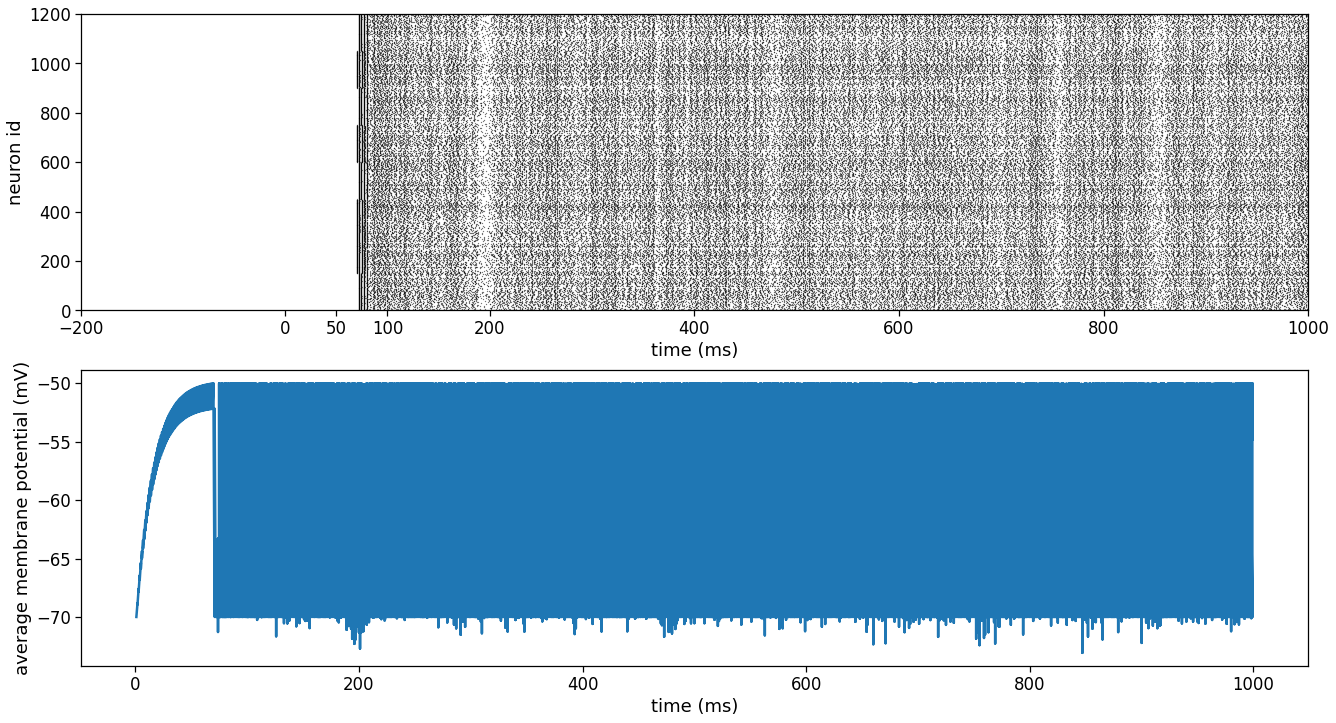

In [255]:
f = plt.figure(figsize=(22,12))
plt.title(list2str(pattern))

plt.subplot(211)
plt.scatter(spike_times,spike_neurons, marker='o', s=.05, color='k');
plt.xlabel('time (ms)')
plt.ylabel('neuron id')
plt.axis([-100,1000,0, N_total])
plt.xticks(list(plt.xticks()[0]) + [50,stim_end]); # add some extra ticks for clarity
#plt.savefig(path+str(H.list2str(pattern))) uncommment to save figures

plt.subplot(212)
plt.plot(volt_times, volt_trace)
plt.ylabel('average membrane potential (mV)')
plt.xlabel('time (ms)')

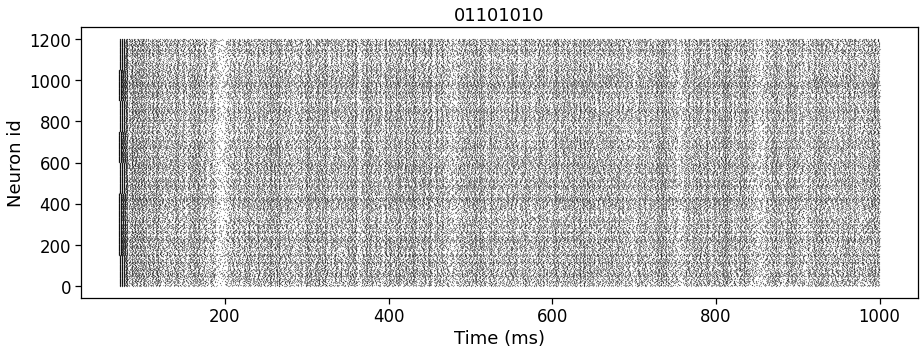

In [251]:
f = plt.figure(figsize=(15,5))
plt.title(list2str(pattern))
plt.scatter(spike_times, spike_neurons, marker='o', s=0.02, color='k');
plt.xlabel('Time (ms)')
plt.ylabel('Neuron id');

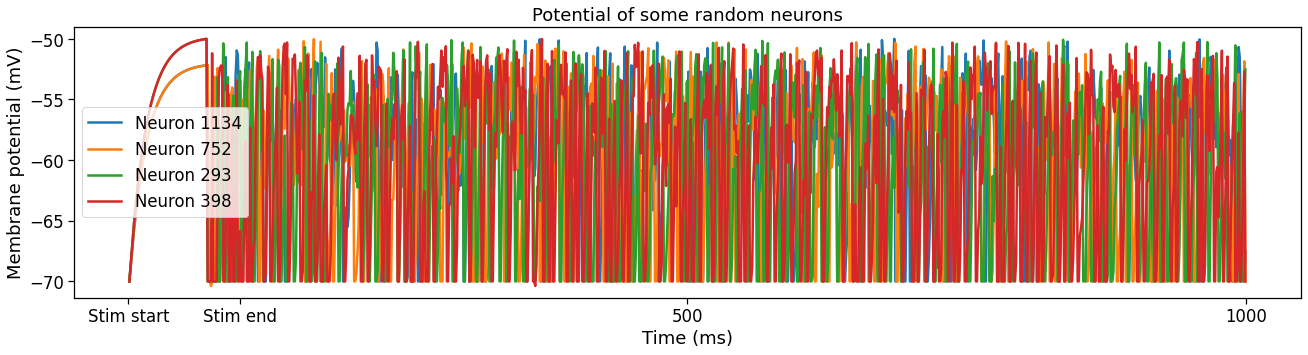

In [247]:
# pick some random indices
rnd_indices = np.random.randint(N_total,size=4)
# voltage trace of few neurons
f = plt.figure(figsize=(22,5))
nest.voltage_trace.from_device(multimet, neurons=rnd_indices, title='Potential of some random neurons');
positions = (stim_start, stim_end, 500, simtime)
labels = ('Stim start', 'Stim end', 500, '1000')
plt.xticks(positions, labels);
plt.legend();

In [248]:
voltage_traces = nest.GetStatus(multimet, 'events')[0]['V_m']
voltage_times = nest.GetStatus(multimet, 'events')[0]['times']

In [249]:
nest.GetStatus(multimet, 'events')[0]

{'senders': array([ 151,  152,  153, ..., 1198, 1199, 1200]),
 'times': array([  1.,   1.,   1., ..., 999., 999., 999.]),
 'V_m': array([-70.        , -70.        , -70.        , ..., -53.2062314 ,
        -70.        , -54.83078629])}

In [250]:
plt.plot(senders, potentials)

NameError: name 'senders' is not defined